In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import os

import numpy as np
import nibabel as nib
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import sys
sys.path.insert(0, '../..')
from utils.utilities import CONTRASTS, GROUP_CONTRAST_IDS, plot_corr_matrices_across_contrasts, compute_corr_coeff


In [3]:
base_data_dir = '/nfs03/data/HCP_200113/derived/preprocessed'

In [4]:
mask = np.load('../../data/glasser_medial_wall_mask.npy')
print(mask.shape)

(2, 32492)


In [6]:
test_subj_ids = np.genfromtxt("sample_HCP_test_retest_subj_ids.csv", dtype='<U13')

test_contrasts = []
for i in range(len(test_subj_ids)):
    subj = test_subj_ids[i]
    contrast_file = os.path.join(base_data_dir, "contrasts", "%s_joint_LR_task_contrasts.npy" % subj)
    contrast_data = np.load(contrast_file)
    test_contrasts.append(contrast_data)

test_contrasts = np.asarray(test_contrasts)
print(test_contrasts.shape)


(5, 94, 32492)


# Retest

In [7]:
retest_contrasts = []

for i in range(len(test_subj_ids)):
    subj = test_subj_ids[i]
    retest_contrast_file = os.path.join(base_data_dir, "HCP_Retest", "contrasts", "%s_joint_LR_task_contrasts.npy" % subj)
    retest_contrast_data = np.load(retest_contrast_file)
    retest_contrasts.append(retest_contrast_data)

retest_contrasts = np.asarray(retest_contrasts)
print(retest_contrasts.shape)

(5, 94, 32492)


In [8]:
def compute_subj_contrast_corr(pred, ref, contrasts, contrast_ids, mask):
    all_lh_corr = []
    all_rh_corr = []
    all_avg_corr = []
    
    masked_lh_pred = pred[:, ::2, mask[0, :]]
    masked_rh_pred = pred[:, 1::2, mask[1, :]]
    
    masked_lh_ref = ref[:, ::2, mask[0, :]]
    masked_rh_ref = ref[:, 1::2, mask[1, :]]

    for i in range(len(contrasts)):
        lh_contrast_ref = masked_lh_ref[:, i, :]
        rh_contrast_ref = masked_rh_ref[:, i, :]
# 
        lh_contrast_pred = masked_lh_pred[:, i, :]
        rh_contrast_pred = masked_rh_pred[:, i, :]
        
#         print(lh_contrast_ref.shape)
#         print(lh_contrast_pred.shape)
#         print(lh_contrast_pred[0, :] - lh_contrast_pred[1, :])
#         print(lh_contrast_ref[0, :] - lh_contrast_ref[1, :])

        lh_corr = compute_corr_coeff(lh_contrast_ref, lh_contrast_pred)
        rh_corr = compute_corr_coeff(rh_contrast_ref, rh_contrast_pred)
        # print(lh_corr[0, :] - lh_corr[1, :])

        all_lh_corr.append(lh_corr)
        all_rh_corr.append(rh_corr)
        all_avg_corr.append((lh_corr + rh_corr) / 2)
    return all_lh_corr, all_rh_corr, all_avg_corr


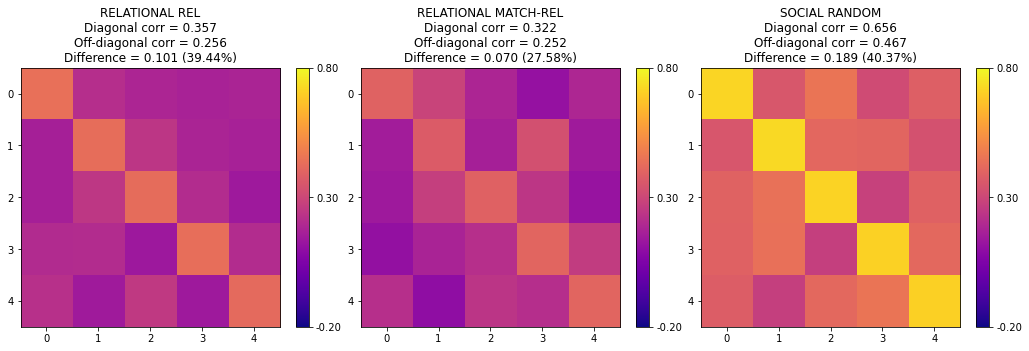

In [9]:
lh_test_retest_corr, rh_test_retest_corr, test_retest_corr = compute_subj_contrast_corr(retest_contrasts, test_contrasts, CONTRASTS, GROUP_CONTRAST_IDS, mask)

plot_corr_matrices_across_contrasts(test_retest_corr, CONTRASTS[4:7], vmax=0.8)


# BrainSurfCNN (trained with MSE)

In [10]:
base_brainsurfcnn_mse_dir = "sample_outputs/test_example_feat64_s8_c50_lr0.01_seed28/predict/best_corr"

multisample_brainsurfcnn_mse_pred = []
for i in range(len(test_subj_ids)):
    subj = test_subj_ids[i]
    pred_file = os.path.join(base_brainsurfcnn_mse_dir, "%s_pred.npy" % subj)
    pred = np.load(pred_file)
    multisample_brainsurfcnn_mse_pred.append(pred)

multisample_brainsurfcnn_mse_pred = np.asarray(multisample_brainsurfcnn_mse_pred)
brainsurfcnn_mse_pred = np.mean(multisample_brainsurfcnn_mse_pred, 1)
print(brainsurfcnn_mse_pred.shape)


(5, 94, 32492)


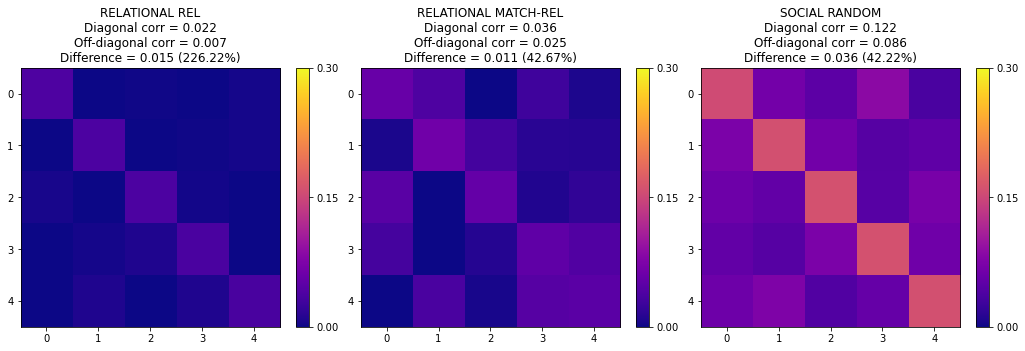

In [16]:
lh_test_brainsurfcnn_mse_corr, rh_test_brainsurfcnn_mse_corr, test_brainsurfcnn_mse_corr = compute_subj_contrast_corr(test_contrasts, brainsurfcnn_mse_pred, CONTRASTS, GROUP_CONTRAST_IDS, mask)

plot_corr_matrices_across_contrasts(test_brainsurfcnn_mse_corr, CONTRASTS[4:7], vmin=0 , vmax=0.3)
